# Feature Selection

### Import required libraries

In [1]:
import sys, os
import itertools
import pandas as pd
import numpy as np

from sklearn.feature_selection import RFECV, SelectFromModel, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils import resample

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def progressBar(value, endvalue, bar_length=50):
    percent = float(value) / endvalue
    arrow = '=' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r[{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))

### Import Data

In [3]:
data = pd.read_csv(os.path.join(os.path.abspath(os.pardir), 'src/dataset', 'data_101718.csv'), low_memory=False)

In [4]:
data.head()

,pid,xnorm,ynorm,znorm,cardistnorm,ca,voxelcount0i,graylevels0i,energy0i,entropy0i,...,srlgle15c,srhgle15c,lrlgle15c,lrhgle15c,extrudedsurfacearea15c,extrudedvolume15c,extrudedsurfacevolumeratio15c,boxcountingdimension15c,informationdimension15c,correlationdimension15c
0,129381,-40.78346,-8.199849,29.363550,50.91901,0,10.0,10.0,2221248.0,0.000000,...,0.000351,17872.487,0.000949,42115.337,4760376.9,10073969.0,0.472542,2.091545,2.098287,-74.249922
1,100676,-53.82082,-38.156560,-3.371359,66.06035,0,351.0,260.0,176300000.0,200.078200,...,0.023536,13326.403,0.107683,45091.633,6061283.1,10260464.0,0.590742,2.065475,2.089445,-73.135671
2,132772,49.27720,-35.530340,-1.662529,60.77345,0,18.0,18.0,2805381.0,0.000000,...,0.000159,54901.246,0.000356,174473.340,6801351.9,11157162.0,0.609595,2.189789,2.194593,-78.016611
3,126967,21.59079,15.484310,27.472460,38.21861,1,1374.0,625.0,135400000.0,1900.617600,...,0.005102,37566.835,0.012797,163982.200,6179906.4,9170642.1,0.673879,2.145406,-0.061130,-76.017566
4,102562,80.64488,16.086080,-69.602640,107.73530,0,173.0,159.0,46611581.0,28.754888,...,0.000151,210927.090,0.000230,671420.660,8901488.9,8746977.7,1.017664,2.117663,-0.058523,-74.898571


In [5]:
data.shape

(3701, 274)

### Data Cleaning 

Let's take a look at the missing data, and try to figure our the best way to clean up our data.

Drop out the columns that have over 90% missing data points.

In [6]:
df = data.dropna(thresh=len(data)*.90, axis=1)

Drop out any rows that are missing more than 50% of the required columns

In [7]:
df = df.dropna(thresh=df.shape[1]*.5)

Drop out any rows that are missing the target value 

In [8]:
df = df.dropna(axis=1, subset=df['ca'])

Fill the rest of missing entries with the mean of each col

In [9]:
df = df.apply(lambda col: col.fillna(col.mean()))

In [10]:
df.isnull().sum().any()

False

In [11]:
features = list(df.columns.values)
features.remove('pid')
features.remove('ca')

In [12]:
X = df[features]
y = df.ca.values

### Recursive Feature Elimination

Find the optimal number of features

In [13]:
rfc=RandomForestClassifier(random_state=2018)

selector = RFECV(
    estimator=rfc, cv=StratifiedKFold(5),
    scoring='roc_auc', verbose=1, n_jobs=-1
).fit(X, y)

Fitting estimator with 268 features.
Fitting estimator with 268 features.
Fitting estimator with 268 features.
Fitting estimator with 268 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
Fitting estimator with 267 features.
Fitting estimator with 267 features.
Fitting estimator with 267 features.
Fitting estimator with 267 features.
Fitting estimator with 266 features.
Fitting estimator with 266 features.
Fitting estimator with 266 features.
Fitting estimator with 266 features.
Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 265 features.
Fitting estimator with 265 features.
Fitting estimator with 265 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 264 features.
Fitting estimator with 264 features.
Fitting estimator with 264 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 263 features.
F

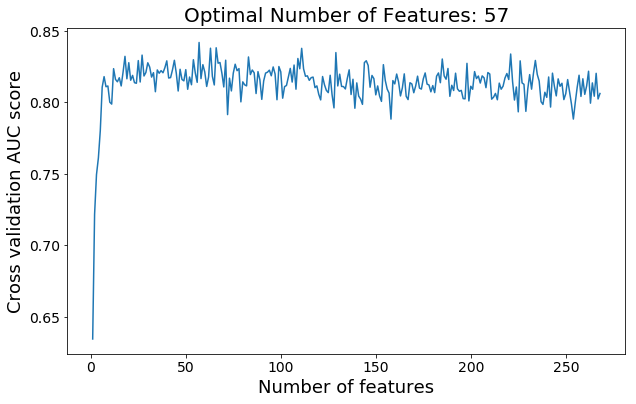

In [14]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.xlabel('Number of features', fontsize=18)
plt.ylabel('Cross validation AUC score', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Optimal Number of Features: {}'.format(selector.n_features_), fontsize=20)
plt.show()

In [15]:
ranks = pd.DataFrame(list(zip(features, selector.ranking_)),columns=['Feature', 'Rank'])
ranks = ranks.sort_values(by='Rank')
ranks.head(60)

,Feature,Rank
0,xnorm,1
145,rootmeansquare15b,1
266,informationdimension15c,1
130,extrudedsurfacearea10b,1
126,srlgle10b,1
123,rp10b,1
119,sre10b,1
94,compactness210b,1
86,laa950perc10b,1
71,energy10b,1


### Benchmark

Let's balance out the pos and neg samples in the dataset

In [16]:
df_neg = df[df.ca==0]
df_pos = df[df.ca==1]

Upsample the pos samples

In [17]:
df_pos_upsampled = resample(
    df_pos,
    n_samples=len(df_neg),
    replace=True, 
    random_state=2018
)
df_upsampled = pd.concat([df_pos_upsampled, df_neg])

Downsample the neg samples

In [18]:
df_neg_downsampled = resample(
    df_neg,
    n_samples=len(df_pos),
    replace=True, 
    random_state=2018
)
df_downsampled = pd.concat([df_pos, df_neg_downsampled])

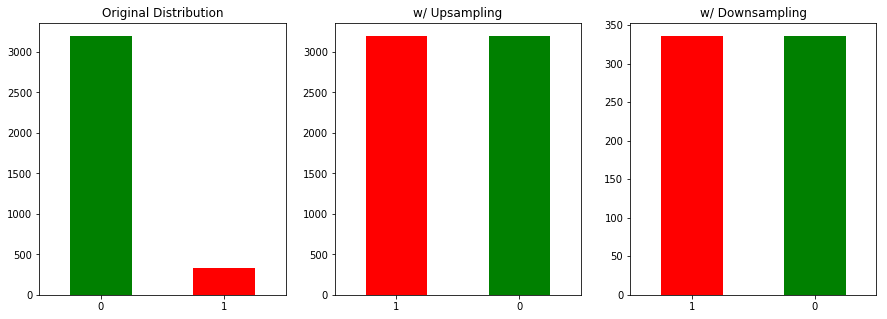

In [19]:
fig, axes = plt.subplots(figsize=(15,5), nrows=1, ncols=3)
df.ca.value_counts().plot.bar(ax=axes[0], rot=False, title='Original Distribution', color=['g','r'])
df_upsampled.ca.value_counts().plot.bar(ax=axes[1], rot=False, title='w/ Upsampling', color=['r','g'])
df_downsampled.ca.value_counts().plot.bar(ax=axes[2], rot=False, title='w/ Downsampling', color=['r','g'])

### Setup Classifier

Normalize Data

In [20]:
selected_features = ranks.Feature[ranks.Rank == 1].values

# original distribution
#X = StandardScaler().fit_transform(df[selected_features])
#y = df.ca.values

# w/upsampling
#X = StandardScaler().fit_transform(df_upsampled[selected_features])
#y = df_upsampled.ca.values

# w/downsampling
X = StandardScaler().fit_transform(df_downsampled[selected_features])
y = df_downsampled.ca.values

Specify parameters to test

In [21]:
rfc=RandomForestClassifier(random_state=2018)
param_grid = { 
    'n_estimators': [100, 300, 500],
    'max_features': ['auto', 'sqrt'],
    'criterion'   : ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample'],
}

Find the best parameters with GridSearchCV for (parallel 5 folds cross-validation)

In [22]:
%%time
optimizer = GridSearchCV(
    rfc, param_grid=param_grid, cv=5, 
    scoring='roc_auc', verbose=10, n_jobs=-1
).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100, score=0.9243079584775087, total=   0.4s
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100, score=0.8691245266206281, total=   0.4s
[CV]  class_weight=balanced, criterion=gini, m

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s


[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300, score=0.9261461937716263, total=   1.2s
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300, score=0.8601024727110715, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=500 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300, score=0.8690131432390288, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=500 
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300, score=0.8425038984183559, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300, score=0.9200267320115839, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s


[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8691245266206281, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8550902205390956, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8379371797727779, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=500, score=0.868344842949432, total=   2.0s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100, score=0.9221430162619737, total=   0.4s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_es

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s


[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=500, score=0.845177099576743, total=   2.0s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=500 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300, score=0.8690131432390288, total=   1.2s
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=500, score=0.9200267320115839, total=   2.0s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=500 
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=500 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300, score=0.9261461937716263, total=   1.2s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=500 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300, score=0.8425038984183559, total=   1.2s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s


[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100, score=0.9269031141868512, total=   0.5s
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100, score=0.8766985965693919, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100, score=0.874582312319002, total=   0.5s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=500, score=0.9254974048442908, total=   2.0s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100, score=0.8418355981287592, total=   0.5s
[CV] class_weight=balanced, criterion=entro

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s


[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300, score=0.935878027681661, total=   1.5s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300, score=0.8748050790822008, total=   1.5s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300, score=0.8481844508799287, total=   1.5s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300, score=0.8728001782134106, total=   1.6s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=100, score=0.9269031141868512, total=   0.5s
[CV] class_weight=balanced, criterion=en

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.6s


[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500, score=0.8734684785030072, total=   2.6s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500, score=0.9350129757785467, total=   2.6s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500, score=0.8753619959901983, total=   2.6s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=500 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500, score=0.85208286923591, total=   2.6s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=500 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500, score=0.9247048340387615, total=   2.6s
[CV] class_weight=balanced, criterion=ent

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.0s


[CV]  class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=100, score=0.868344842949432, total=   0.6s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=100, score=0.8609935397638673, total=   0.6s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=100, score=0.8320338605480064, total=   0.6s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=100, score=0.9209177990643796, total=   0.6s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=500, score=0.9350129757785467

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   13.2s


[CV]  class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=300, score=0.9211405658275785, total=   1.9s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100, score=0.9201989619377162, total=   0.6s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100, score=0.868344842949432, total=   0.6s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8609935397638673, total=   0.6s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100, score=0.832033860

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   16.1s


[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100, score=0.9271193771626298, total=   0.6s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=300, score=0.8400534640231677, total=   1.7s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=300, score=0.9211405658275785, total=   1.7s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100, score=0.871240810871018, total=   0.6s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=1

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.8s


[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=300, score=0.8705725105814212, total=   2.1s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=300, score=0.8513031855647138, total=   2.1s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=300, score=0.9254845177099578, total=   2.1s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=100, score=0.9271193771626298, total=   0.7s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estim

[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   25.5s remaining:    0.4s


[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=500, score=0.9235910002227667, total=   2.1s


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   25.8s finished


CPU times: user 2.09 s, sys: 222 ms, total: 2.31 s
Wall time: 27.5 s


In [23]:
optimizer.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': 'auto',
 'n_estimators': 500}

Run classifier with cross-validation and claculate the accuracy of the model based on True-Positive and False-Positive predictions

[=================================================>] 100%

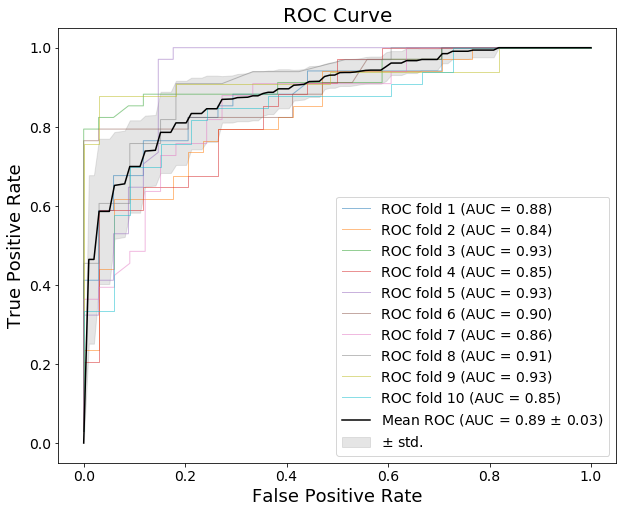

In [24]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2018).split(X, y)
classifier = RandomForestClassifier(**optimizer.best_params_)

tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,8))

for itr, (train, test) in enumerate(cv):
    progressBar(itr+1, n_splits) 
    
    # get predictions
    probs = classifier.fit(X[train], y[train]).predict_proba(X[test])
    
    # compute AUC
    fpr, tpr, thresholds = roc_curve(y[test], probs[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(
        fpr, tpr, lw=1, alpha=0.5,
        label='ROC fold %d (AUC = %0.2f)' % (itr+1, roc_auc)
    )

# plot avg AUC    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr, mean_tpr, color='k',
    label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc)
)

# plot std
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr, tprs_lower, tprs_upper,
    color='grey', alpha=.2, label=r'$\pm$ std.'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc="lower right", fontsize=14)
plt.show()

[=================================================>] 100%

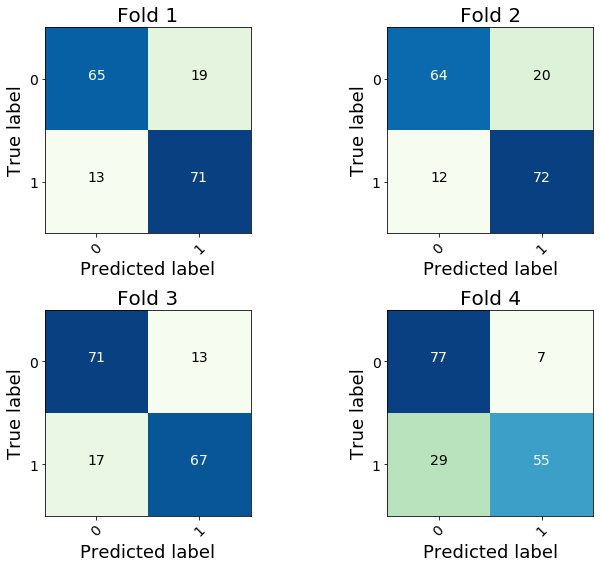

In [25]:
n_splits = 4
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2018).split(X, y)
classifier = RandomForestClassifier(**optimizer.best_params_)
classes = df.ca.unique()

fig = plt.figure(figsize=(10,8))
for itr, (train, test) in enumerate(cv):
    progressBar(itr+1, n_splits) 
        
    # get predictions
    y_pred = classifier.fit(X[train], y[train]).predict(X[test])
    
    # compute confusion matrix
    matrix = confusion_matrix(y[test], y_pred)
    
    # plot confusion matrix
    ax = fig.add_subplot(2,2,itr+1)
    ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.GnBu)
    
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(
            j, i, format(matrix[i, j], 'd'),
            horizontalalignment="center",
            fontsize=14, color="white" if matrix[i, j] > matrix.max()/2 else "black"
        )
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.title('Fold %d' % (itr+1), fontsize=20)

plt.tight_layout()